# Introduction and Business Problem

**Introduction:**
The city of Lviv, ukraine is the largest city in western Ukraine and the seventh-largest city in the country overall, with a population of 724,241 as of 2020. Lviv is one of the main cultural centres of Ukraine. Simply put Lviv is just one of the most beautiful and tourist city in Europe yet underrated.  For people that are new to Lviv, due its geographic size, it can be daunting to figure out what restaurants are worth going to based on their current location. For people living in Lviv or are visiting Lviv, how do you know what are the best places to get delicious meal or drinks?

**Business Problem:**
For this project, I am going to create a simple guide on where to eat based on Foursquare **likes, restaurant category and geographic location data for restaurants in Lviv**. I will then cluster these restaurants based on their similarities so that a user can easily determine what type of restaurants are best to eat at based on Foursquare user feedback.

# Data Required
For this assignment, I will be utilizing the Foursquare API to pull the following location data on restaurants in LVIV, UKRAINE:

 - Venue Name
 - Venue ID
 - Venue Location
 - Venue Category
 - Count of Likes

# Data Acquisition Approach

To acquire the data mentioned above, I will need to do the following:
 - Get lat and long coordinates for Lviv via Geocoder package.
 - Use Foursquare API to get a list of all venues in Lviv
 - Get venue name, venue ID, location, category, and likes

# Machine learning
I will take the gathered data (see above in Data Acquisition Approach and Data Required sections) and will create a k-means clustering algorithm that groups restaurants into 4-5 clusters so that people looking to eat in Lviv can easily see which restaurants are the best, what cuisine is available and where in Lviv they can get a good meal.

## Data Prep and Pull
We will import our necessary packages and start pulling our data for data prep and usage.

In [24]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#import beautiful soup
from urllib.request import urlopen
from bs4 import BeautifulSoup


print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


# Finding the geo data for Lviv
Let's find the geographic data for Lviv so we can pull it from FourSquare.

In [25]:
address = 'Lviv, Ukraine'

geolocator = Nominatim(user_agent="Lviv-venues")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(f'The geographical coordinate of Lviv are {latitude}, {longitude}')


The geographical coordinate of Lviv are 49.841952, 24.0315921


## Foursquare: credentials 
**Enter credentials to access Foursquare API.**

In [26]:
CLIENT_ID = 'JBIV55ISI3AEDWFGDQR2IH2PY2P3FTRSEJ2Z4NDVEUCM2KLB' 
CLIENT_SECRET = 'W4OLEZU1RZKSX5YVUY3DWJYATIQY0PAQD0PNCKJI1ZGNY32H' 
VERSION = '20200101' 

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JBIV55ISI3AEDWFGDQR2IH2PY2P3FTRSEJ2Z4NDVEUCM2KLB
CLIENT_SECRET:W4OLEZU1RZKSX5YVUY3DWJYATIQY0PAQD0PNCKJI1ZGNY32H


## Foursquare: get venues
**Let's get the top 100 venues that are in lviv(from the center) within a radius of 2000 meters**

In [27]:
LIMIT = 300 # limit the number of venues returned by Foursquare API
RADIUS = 7500 # this radius 7.5km allow us to cover almost all venues in the city of Lviv

url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}\
&client_secret={CLIENT_SECRET}\
&v={VERSION}\
&ll={latitude},{longitude}\
&radius={RADIUS}\
&limit={LIMIT}'

url

'https://api.foursquare.com/v2/venues/explore?&client_id=JBIV55ISI3AEDWFGDQR2IH2PY2P3FTRSEJ2Z4NDVEUCM2KLB&client_secret=W4OLEZU1RZKSX5YVUY3DWJYATIQY0PAQD0PNCKJI1ZGNY32H&v=20200101&ll=49.841952,24.0315921&radius=7500&limit=300'

In [28]:
import pprint

# send a get request
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e96a12c47b43d0023711422'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'With specials', 'key': 'specials'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Lviv',
  'headerFullLocation': 'Lviv',
  'headerLocationGranularity': 'city',
  'totalResults': 214,
  'suggestedBounds': {'ne': {'lat': 49.90945206750007,
    'lng': 24.136064450177383},
   'sw': {'lat': 49.77445193249993, 'lng': 23.92711974982262}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5cf98f4e588e36002cd812b8',
       'name': 'EROS Show Bar',
       'location': {'address': 'пл. Рынок, 11',
        'crossStreet': 'пл. Рынок, 11',
        'lat': 49.841434,
        'lng': 24.03277,
        'labeledLatLngs': [{'

## Create dataframe with data retrieved from FourSquare API

In [29]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    
    if len(categories_list) == 0:
        return None
    else: 
        return categories_list[0]['name']

In [30]:
# pull data from Fourquare and store them into a dataframe
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
filtered_columns = ['venue.id', 'venue.name', 'venue.categories', 'venue.location.address',\
                    'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# get category's name for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues

,venue.id,venue.name,venue.categories,venue.location.address,venue.location.lat,venue.location.lng
0,5cf98f4e588e36002cd812b8,EROS Show Bar,Strip Club,"пл. Рынок, 11",49.841434,24.032770
1,4c98f76cf419a09382417488,Площа Ринок,Plaza,пл. Ринок,49.841625,24.031056
2,573069e7498eedd42e6399f3,"Apart-hotel ""Horowitz""",Hotel,Krakivska 4,49.842508,24.030381
3,5d26dc5b348eba0023c8ede8,SDV Coffee Shop,Coffee Shop,"вул. Краківська, 23",49.844174,24.029426
4,4dea00de88774880e3100871,Домініканський собор,Church,"пл. Музейна, 1",49.842757,24.033800
5,5d14cc333f069d002365590b,Львівські Млинці,Creperie,Братів Рогатинців 41,49.840673,24.033805
6,54b69c3a498e7aea12b2bba9,Ресторація Бачевських,West-Ukrainian Restaurant,"вул. Шевська, 8",49.842168,24.029843
7,4ee1fd419a521fcbef3153e0,Гарнізонний храм Петра і Павла,Church,"вул. Театральна, 11",49.841718,24.029446
8,4d03b490e350b60c81b97e42,Львівська майстерня шоколаду,Chocolate Shop,"вул. Сербська, 3",49.841254,24.033434
9,5575cf6d498e61b30167a7d1,Rhizome Store,Women's Store,"Вул. Братів Рогатитнців, 24",49.840659,24.034077


**Let's fix column name**

In [31]:
nearby_venues.columns = [col.split('.')[-1] for col in nearby_venues.columns]
nearby_venues

,id,name,categories,address,lat,lng
0,5cf98f4e588e36002cd812b8,EROS Show Bar,Strip Club,"пл. Рынок, 11",49.841434,24.032770
1,4c98f76cf419a09382417488,Площа Ринок,Plaza,пл. Ринок,49.841625,24.031056
2,573069e7498eedd42e6399f3,"Apart-hotel ""Horowitz""",Hotel,Krakivska 4,49.842508,24.030381
3,5d26dc5b348eba0023c8ede8,SDV Coffee Shop,Coffee Shop,"вул. Краківська, 23",49.844174,24.029426
4,4dea00de88774880e3100871,Домініканський собор,Church,"пл. Музейна, 1",49.842757,24.033800
5,5d14cc333f069d002365590b,Львівські Млинці,Creperie,Братів Рогатинців 41,49.840673,24.033805
6,54b69c3a498e7aea12b2bba9,Ресторація Бачевських,West-Ukrainian Restaurant,"вул. Шевська, 8",49.842168,24.029843
7,4ee1fd419a521fcbef3153e0,Гарнізонний храм Петра і Павла,Church,"вул. Театральна, 11",49.841718,24.029446
8,4d03b490e350b60c81b97e42,Львівська майстерня шоколаду,Chocolate Shop,"вул. Сербська, 3",49.841254,24.033434
9,5575cf6d498e61b30167a7d1,Rhizome Store,Women's Store,"Вул. Братів Рогатитнців, 24",49.840659,24.034077


**Find a list of unique categories**

In [32]:
nearby_venues['categories'].unique()

array(['Strip Club', 'Plaza', 'Hotel', 'Coffee Shop', 'Church',
       'Creperie', 'West-Ukrainian Restaurant', 'Chocolate Shop',
       "Women's Store", 'Gastropub', 'Wine Bar', 'Cheese Shop',
       'Hookah Bar', 'Opera House', 'Bookstore', 'French Restaurant',
       'Beer Bar', 'Monument / Landmark', 'BBQ Joint', 'Historic Site',
       'Fountain', 'Café', 'Burger Joint', 'Cocktail Bar', 'Park',
       'Restaurant', 'Vietnamese Restaurant', 'Pizza Place',
       'Dessert Shop', 'Caucasian Restaurant', 'Movie Theater',
       'Sushi Restaurant', 'Lounge', 'Italian Restaurant', 'Steakhouse',
       'Breakfast Spot', 'Brewery', 'Asian Restaurant', 'Bed & Breakfast',
       'Shopping Mall', 'Turkish Restaurant', 'Supermarket', 'Irish Pub',
       'Vegetarian / Vegan Restaurant', 'Palace', 'Mountain',
       'Scenic Lookout', 'Wine Shop', 'Gym / Fitness Center',
       'Tatar Restaurant', 'Bakery', 'Convenience Store', 'Forest',
       'Pool', 'Sandwich Place', 'Photography Studio'], dt

**Clean our dataframe in other to have just categories related to "restaurant / bar"**

In [33]:
places_list = ['Creperie','Coffee Shop', 'West-Ukrainian Restaurant', 'Chocolate Shop',
        'Gastropub', 'Wine Bar','Karaoke Bar', 'Hookah Bar','French Restaurant',
       'BBQ Joint','Café', 'Beer Bar', 'Burger Joint',
       'Restaurant', 'Lounge', 'Italian Restaurant',
       'Cocktail Bar', 'Pizza Place', 'Vietnamese Restaurant',
       'Caucasian Restaurant', 'Breakfast Spot', 'Steakhouse',
       'Sushi Restaurant', 'Turkish Restaurant', 'Asian Restaurant',
       'Brewery','Vegetarian / Vegan Restaurant',
        'Irish Pub','Shopping Mall','Tatar Restaurant', 'Sandwich Place']

nearby_venues_2 = nearby_venues.copy()

## dataframes with categories (restaurants/bar)
nearby_venues_2 = nearby_venues_2[nearby_venues_2['categories'].isin(places_list)]
nearby_venues_2.reset_index(drop=True, inplace=True)
nearby_venues_2


,id,name,categories,address,lat,lng
0,5d26dc5b348eba0023c8ede8,SDV Coffee Shop,Coffee Shop,"вул. Краківська, 23",49.844174,24.029426
1,5d14cc333f069d002365590b,Львівські Млинці,Creperie,Братів Рогатинців 41,49.840673,24.033805
2,54b69c3a498e7aea12b2bba9,Ресторація Бачевських,West-Ukrainian Restaurant,"вул. Шевська, 8",49.842168,24.029843
3,4d03b490e350b60c81b97e42,Львівська майстерня шоколаду,Chocolate Shop,"вул. Сербська, 3",49.841254,24.033434
4,5bed86defc9e94002c89ba51,Чотири чебуреки / 4 chebureks,Gastropub,"вул. Староєврейська, 16",49.840523,24.032524
5,56350e28498e6c1e1429102d,П'яна Вишня,Wine Bar,"пл. Ринок, 11",49.841522,24.032657
6,5b2631138d0a530039b078e8,П'яна Вишня,Wine Bar,"вул. Кракiвська, 1",49.842386,24.030350
7,5d2df46b7226a500247d0749,Chilling,Hookah Bar,19 Свободи проспект,49.841644,24.026845
8,55f2cd0a498e8eb6624b2ce1,Tante Sophie Cafe Escargot,French Restaurant,"вул. Друкарська, 6A",49.843552,24.032115
9,5a2046b5fd16bb0d884e800e,Золотий колос,Beer Bar,Крива липа 6,49.840607,24.026194


## Get "Likes" from Foursquares dataframes and add them to our dataframe

**Get the list of venue's id**

In [34]:
venue_ids = nearby_venues_2['id'].tolist()
venue_ids

['5d26dc5b348eba0023c8ede8',
 '5d14cc333f069d002365590b',
 '54b69c3a498e7aea12b2bba9',
 '4d03b490e350b60c81b97e42',
 '5bed86defc9e94002c89ba51',
 '56350e28498e6c1e1429102d',
 '5b2631138d0a530039b078e8',
 '5d2df46b7226a500247d0749',
 '55f2cd0a498e8eb6624b2ce1',
 '5a2046b5fd16bb0d884e800e',
 '58ce641718fd2b1c6aff47f8',
 '57bb3613498e86d2c0c99f1d',
 '568fe49f498e56870f8114d4',
 '5bd73112237dee002c3b8d7f',
 '5cc0a962cbcdee002c2c0ff3',
 '5bf7f6e51c0b34002c022010',
 '5c48d96c35f983002c7d7983',
 '4ef81686c512f227791e4789',
 '5852de1cea1c0d49117fb8dc',
 '4bff5a0bc30a2d7fe0e6101d',
 '593c079cf0b490219461d8c5',
 '557fd7fd498eca6e4d5cfbfb',
 '4bd137e7caff9521946fd0f0',
 '592acda4c8b2fb4f25f0e3d3',
 '57239516498e4a0a394fa07d',
 '4fef25c6e4b0b1e83186060c',
 '57fd0ca9498e3bc5cd775cb6',
 '52617f0411d23f2f71e102fd',
 '5853d039ce593d53048eb53a',
 '5130eb51e4b018c1b228b9c1',
 '528fc78611d2fae86590fce0',
 '560ad8e6498e227e0460fc6b',
 '4e0df9b97d8bb178a8a40c62',
 '5662e161498e680e97ac2041',
 '544e28dc498e

**Pull the count of likes per venues**

In [35]:
url_list = []
like_list = []
json_list = []

for i in venue_ids:
    venue_url = f'https://api.foursquare.com/v2/venues/{i}/likes?client_id={CLIENT_ID}\
        &client_secret={CLIENT_SECRET}\
        &v={VERSION}'
    url_list.append(venue_url)
    
for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    like_list.append(likes)
    
print(like_list)

[89, 38, 3439, 3713, 215, 1370, 71, 17, 609, 89, 22, 338, 1161, 48, 37, 174, 38, 4573, 240, 430, 140, 521, 1491, 113, 388, 1054, 174, 308, 352, 1701, 1803, 671, 3702, 607, 1198, 2521, 39, 3, 2115, 29, 2128, 132, 131, 125, 21, 2224, 11, 66, 120, 50]


In [36]:
# check that we have as much "likes" as "venue id"
print(len(like_list))
print(len(venue_ids))

50
50


# Data Processing:

Here we have chosen **likes** as an indicator of quality, so the higher number of likes a restaurant/bar got, the better is the quality of the restaurant. This might be very simplistic way of evaluating the quality of a restaurant but due to limited amount of calls we can make to the api(as we use the free account) we cannot dig deeper into details to get more specific information(prices, ratings, comments)

**Copy our initial dataframe**

In [37]:
lviv_venues = nearby_venues_2.copy()
lviv_venues.head()

,id,name,categories,address,lat,lng
0,5d26dc5b348eba0023c8ede8,SDV Coffee Shop,Coffee Shop,"вул. Краківська, 23",49.844174,24.029426
1,5d14cc333f069d002365590b,Львівські Млинці,Creperie,Братів Рогатинців 41,49.840673,24.033805
2,54b69c3a498e7aea12b2bba9,Ресторація Бачевських,West-Ukrainian Restaurant,"вул. Шевська, 8",49.842168,24.029843
3,4d03b490e350b60c81b97e42,Львівська майстерня шоколаду,Chocolate Shop,"вул. Сербська, 3",49.841254,24.033434
4,5bed86defc9e94002c89ba51,Чотири чебуреки / 4 chebureks,Gastropub,"вул. Староєврейська, 16",49.840523,24.032524


**Add a column 'Likes' to our dataframe**

In [38]:
lviv_venues['likes'] = like_list
lviv_venues.head()

,id,name,categories,address,lat,lng,likes
0,5d26dc5b348eba0023c8ede8,SDV Coffee Shop,Coffee Shop,"вул. Краківська, 23",49.844174,24.029426,89
1,5d14cc333f069d002365590b,Львівські Млинці,Creperie,Братів Рогатинців 41,49.840673,24.033805,38
2,54b69c3a498e7aea12b2bba9,Ресторація Бачевських,West-Ukrainian Restaurant,"вул. Шевська, 8",49.842168,24.029843,3439
3,4d03b490e350b60c81b97e42,Львівська майстерня шоколаду,Chocolate Shop,"вул. Сербська, 3",49.841254,24.033434,3713
4,5bed86defc9e94002c89ba51,Чотири чебуреки / 4 chebureks,Gastropub,"вул. Староєврейська, 16",49.840523,24.032524,215


In [39]:
lviv_venues['likes'].describe()

count      50.00000
mean      812.98000
std      1143.33639
min         3.00000
25%        67.25000
50%       227.50000
75%      1188.75000
max      4573.00000
Name: likes, dtype: float64

**Visualize distribution of likes** 

(array([36.,  9.,  1.,  4.]),
 array([3.0000e+00, 1.1455e+03, 2.2880e+03, 3.4305e+03, 4.5730e+03]),
 <a list of 4 Patch objects>)

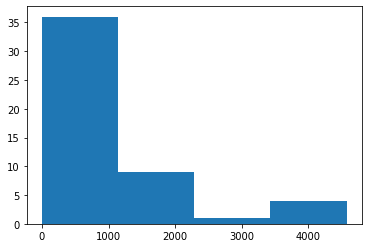

In [40]:
plt.hist(lviv_venues['likes'], bins=4)

In [41]:
print(np.percentile(lviv_venues['likes'], 25))
print(np.percentile(lviv_venues['likes'], 50))
print(np.percentile(lviv_venues['likes'], 75))

67.25
227.5
1188.75


**Add a new column "likes_cat" to our data frame to categorize the "Likes"**
Based on the percentile above we will create 4 categories
   - less than 71         -> Poor
   - between 71 and 240   -> average
   - between 240 and 1198 -> good
   - more than 1198       -> excellent

In [42]:
def categorize(likes):
    '''
    Function that categorize our restaurant based on 'likes'
    '''
    if likes <= 71:
        return 'Poor'
    elif likes <= 240: 
        return 'Average'
    elif likes <= 1198:
        return 'Good'
    else:
        return 'Excellent'
    
lviv_venues['likes_cat'] = lviv_venues['likes'].apply(categorize)

In [43]:
lviv_venues

,id,name,categories,address,lat,lng,likes,likes_cat
0,5d26dc5b348eba0023c8ede8,SDV Coffee Shop,Coffee Shop,"вул. Краківська, 23",49.844174,24.029426,89,Average
1,5d14cc333f069d002365590b,Львівські Млинці,Creperie,Братів Рогатинців 41,49.840673,24.033805,38,Poor
2,54b69c3a498e7aea12b2bba9,Ресторація Бачевських,West-Ukrainian Restaurant,"вул. Шевська, 8",49.842168,24.029843,3439,Excellent
3,4d03b490e350b60c81b97e42,Львівська майстерня шоколаду,Chocolate Shop,"вул. Сербська, 3",49.841254,24.033434,3713,Excellent
4,5bed86defc9e94002c89ba51,Чотири чебуреки / 4 chebureks,Gastropub,"вул. Староєврейська, 16",49.840523,24.032524,215,Average
5,56350e28498e6c1e1429102d,П'яна Вишня,Wine Bar,"пл. Ринок, 11",49.841522,24.032657,1370,Excellent
6,5b2631138d0a530039b078e8,П'яна Вишня,Wine Bar,"вул. Кракiвська, 1",49.842386,24.030350,71,Poor
7,5d2df46b7226a500247d0749,Chilling,Hookah Bar,19 Свободи проспект,49.841644,24.026845,17,Poor
8,55f2cd0a498e8eb6624b2ce1,Tante Sophie Cafe Escargot,French Restaurant,"вул. Друкарська, 6A",49.843552,24.032115,609,Good
9,5a2046b5fd16bb0d884e800e,Золотий колос,Beer Bar,Крива липа 6,49.840607,24.026194,89,Average


**Let's create a column "new_categories" in other to put into groups our categories of restaurant**

   - **Bar** is an establishment licensed to serve alcoholic beverages and is named after the counter or bar on which drinks are served.

   - **Pub** is short for Public House licensed to serve alcoholic beverages and called so in countries or establishments with a British influence

   - **Restaurant** a place where people pay to sit and eat meals that are cooked and served on the premises.

In [44]:
lviv_venues['categories'].unique()

array(['Coffee Shop', 'Creperie', 'West-Ukrainian Restaurant',
       'Chocolate Shop', 'Gastropub', 'Wine Bar', 'Hookah Bar',
       'French Restaurant', 'Beer Bar', 'BBQ Joint', 'Café',
       'Burger Joint', 'Cocktail Bar', 'Restaurant',
       'Vietnamese Restaurant', 'Pizza Place', 'Caucasian Restaurant',
       'Sushi Restaurant', 'Lounge', 'Italian Restaurant', 'Steakhouse',
       'Breakfast Spot', 'Brewery', 'Asian Restaurant', 'Shopping Mall',
       'Turkish Restaurant', 'Irish Pub', 'Vegetarian / Vegan Restaurant',
       'Tatar Restaurant', 'Sandwich Place'], dtype=object)

In [48]:
bars =['Wine Bar', 'Hookah Bar','Beer Bar','Cocktail Bar', 'Brewery', 'Irish Pub', 'Gastropub']
others = ['Coffee Shop', 'Creperie','Chocolate Shop', 'Café', 'Sandwich Place','Breakfast Spot']
ukrainian_food = ['West-Ukrainian Restaurant', 'Tatar Restaurant', 'Restaurant']
italian_food = ['Pizza Place','Italian Restaurant']
asian_food = ['Vietnamese Restaurant', 'Sushi Restaurant', 'Asian Restaurant']
euro_american_food = ['French Restaurant','BBQ Joint', 'Burger Joint', 'Caucasian Restaurant'
                      ,'Lounge', 'Steakhouse', 'Turkish Restaurant', 'Vegetarian / Vegan Restaurant']

def categorize_restaurant(category): 
    if category in bars:
        return 'Bars'
    elif category in others:
        return 'Others'
    elif category in ukrainian_food: 
        return 'Ukrainian food'
    elif category in italian_food: 
        return 'Italian food'
    elif category in asian_food: 
        return 'Asian food'
    elif category in euro_american_food: 
        return 'Euro-American food'
    
lviv_venues['new_categories'] = lviv_venues['categories'].apply(categorize_restaurant)

In [49]:
lviv_venues

,id,name,categories,address,lat,lng,likes,likes_cat,new_categories
0,5d26dc5b348eba0023c8ede8,SDV Coffee Shop,Coffee Shop,"вул. Краківська, 23",49.844174,24.029426,89,Average,Others
1,5d14cc333f069d002365590b,Львівські Млинці,Creperie,Братів Рогатинців 41,49.840673,24.033805,38,Poor,Others
2,54b69c3a498e7aea12b2bba9,Ресторація Бачевських,West-Ukrainian Restaurant,"вул. Шевська, 8",49.842168,24.029843,3439,Excellent,Ukrainian food
3,4d03b490e350b60c81b97e42,Львівська майстерня шоколаду,Chocolate Shop,"вул. Сербська, 3",49.841254,24.033434,3713,Excellent,Others
4,5bed86defc9e94002c89ba51,Чотири чебуреки / 4 chebureks,Gastropub,"вул. Староєврейська, 16",49.840523,24.032524,215,Average,Bars
5,56350e28498e6c1e1429102d,П'яна Вишня,Wine Bar,"пл. Ринок, 11",49.841522,24.032657,1370,Excellent,Bars
6,5b2631138d0a530039b078e8,П'яна Вишня,Wine Bar,"вул. Кракiвська, 1",49.842386,24.030350,71,Poor,Bars
7,5d2df46b7226a500247d0749,Chilling,Hookah Bar,19 Свободи проспект,49.841644,24.026845,17,Poor,Bars
8,55f2cd0a498e8eb6624b2ce1,Tante Sophie Cafe Escargot,French Restaurant,"вул. Друкарська, 6A",49.843552,24.032115,609,Good,Euro-American food
9,5a2046b5fd16bb0d884e800e,Золотий колос,Beer Bar,Крива липа 6,49.840607,24.026194,89,Average,Bars


**Let's create dummies variables for our 'likes' and 'new_categories' in other to apply clustering later on**

In [51]:
# one hot encoding 
lviv_onehot = pd.get_dummies(lviv_venues[['new_categories', 'likes_cat']])

# Add "name" to lviv_onehot 
lviv_onehot['name'] = lviv_venues['name']

# move the columns 'name' to the first column
fixed_columns = [lviv_onehot.columns[-1]] + list(lviv_onehot.columns[:-1])
lviv_onehot = lviv_onehot[fixed_columns]

lviv_onehot.head()

,name,new_categories_Asian food,new_categories_Bars,new_categories_Euro-American food,new_categories_Italian food,new_categories_Others,new_categories_Ukrainian food,likes_cat_Average,likes_cat_Excellent,likes_cat_Good,likes_cat_Poor
0,SDV Coffee Shop,0,0,0,0,1,0,1,0,0,0
1,Львівські Млинці,0,0,0,0,1,0,0,0,0,1
2,Ресторація Бачевських,0,0,0,0,0,1,0,1,0,0
3,Львівська майстерня шоколаду,0,0,0,0,1,0,0,1,0,0
4,Чотири чебуреки / 4 chebureks,0,1,0,0,0,0,1,0,0,0


## Clustering 

**Let's run K-means clustering**

In [65]:
cluster_df = lviv_onehot.drop('name', axis=1)

# number of clusters
k_clusters = 4

# run K-means clusteriing
kmeans = KMeans(n_clusters=k, random_state=0).fit(cluster_df)

# check cluster labels generated for each row in the data frame
kmeans.labels_[0:10]


array([1, 0, 2, 2, 1, 2, 0, 0, 3, 1], dtype=int32)

**Let's add our cluster labels to our original dataframe lviv_venues**

In [66]:
lviv_venues['label'] = kmeans.labels_
lviv_venues.head()

,id,name,categories,address,lat,lng,likes,likes_cat,new_categories,label
0,5d26dc5b348eba0023c8ede8,SDV Coffee Shop,Coffee Shop,"вул. Краківська, 23",49.844174,24.029426,89,Average,Others,1
1,5d14cc333f069d002365590b,Львівські Млинці,Creperie,Братів Рогатинців 41,49.840673,24.033805,38,Poor,Others,0
2,54b69c3a498e7aea12b2bba9,Ресторація Бачевських,West-Ukrainian Restaurant,"вул. Шевська, 8",49.842168,24.029843,3439,Excellent,Ukrainian food,2
3,4d03b490e350b60c81b97e42,Львівська майстерня шоколаду,Chocolate Shop,"вул. Сербська, 3",49.841254,24.033434,3713,Excellent,Others,2
4,5bed86defc9e94002c89ba51,Чотири чебуреки / 4 chebureks,Gastropub,"вул. Староєврейська, 16",49.840523,24.032524,215,Average,Bars,1


**Let's visualize what our clusters look like for the city of Lviv**

In [87]:
map_lviv_clustered = folium.Map(location=[latitude, longitude], zoom_start=11)

## set color scheme for the clusters
rainbow = ['#00bdaa', '#ffa41b', '#fe346e','#400082']
# add markers to the map
markers_colors = []
for lat, lng, name, cluster in zip(lviv_venues['lat'], lviv_venues['lng'], lviv_venues['name'], lviv_venues['label']):
    label = folium.Popup(str(name) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_lviv_clustered)
    
map_lviv_clustered

### Result of the clustering 

    Here will see what we have got in each clusters. this is how we categorized our restaurants:
**bars** = ['Wine Bar', 'Hookah Bar','Beer Bar','Cocktail Bar', 'Brewery', 'Irish Pub', 'Gastropub']   

**others** = ['Coffee Shop', 'Creperie','Chocolate Shop', 'Café', 'Sandwich Place','Breakfast Spot']   

**ukrainian_food** = ['West-Ukrainian Restaurant', 'Tatar Restaurant', 'Restaurant']   

**italian_food** = ['Pizza Place','Italian Restaurant']   

**asian_food** = ['Vietnamese Restaurant', 'Sushi Restaurant', 'Asian Restaurant']   

**euro_american_food** = ['French Restaurant','BBQ Joint', 'Burger Joint', 'Caucasian Restaurant'
                      ,'Lounge', 'Steakhouse', 'Turkish Restaurant', 'Vegetarian / Vegan Restaurant']

### Cluster 1: 

  Characteristics:
   - Poor Quality
   - Mostly **Bars and Others**


In [76]:
lviv_venues[lviv_venues['label'] == 0]

,id,name,categories,address,lat,lng,likes,likes_cat,new_categories,label
1,5d14cc333f069d002365590b,Львівські Млинці,Creperie,Братів Рогатинців 41,49.840673,24.033805,38,Poor,Others,0
6,5b2631138d0a530039b078e8,П'яна Вишня,Wine Bar,"вул. Кракiвська, 1",49.842386,24.030350,71,Poor,Bars,0
7,5d2df46b7226a500247d0749,Chilling,Hookah Bar,19 Свободи проспект,49.841644,24.026845,17,Poor,Bars,0
10,58ce641718fd2b1c6aff47f8,Saturdays Coffee,Coffee Shop,"Митна,1",49.839701,24.035908,22,Poor,Others,0
13,5bd73112237dee002c3b8d7f,Black Honey,Coffee Shop,"вул. Галицька, 20",49.839450,24.031892,48,Poor,Others,0
14,5cc0a962cbcdee002c2c0ff3,Grand Cafe Leopolis,Café,"Rynok sq., 1",49.842137,24.031619,37,Poor,Others,0
16,5c48d96c35f983002c7d7983,Ginger Bar Lviv,Cocktail Bar,"Majera Balabana st, 12",49.846559,24.022485,38,Poor,Bars,0
36,5b8d4ff6018cbb002ca0a164,Green Garden,Asian Restaurant,Руданського 1,49.838294,24.030563,39,Poor,Asian food,0
37,5e0629bba5f58500073efcbb,Marevo Craft&Organic,Pizza Place,"Вірменька, 5",49.843130,24.030391,3,Poor,Italian food,0
39,5b240f73db1d8100394d0f38,Port Wine Bar,Wine Bar,"вул. Валова, 19",49.840102,24.033875,29,Poor,Bars,0


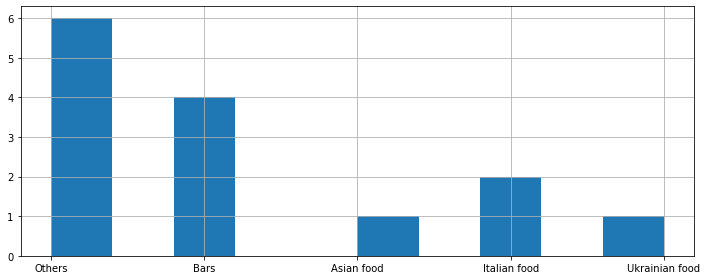

In [86]:
fig = plt.figure(figsize=(10,4))
lviv_venues[lviv_venues['label'] == 0]['new_categories'].hist()
plt.tight_layout()

### Cluster 2: 

  Characteristics:
   - Average Quality
   - Mostly **Euro-american food**


In [88]:
lviv_venues[lviv_venues['label'] == 1]

,id,name,categories,address,lat,lng,likes,likes_cat,new_categories,label
0,5d26dc5b348eba0023c8ede8,SDV Coffee Shop,Coffee Shop,"вул. Краківська, 23",49.844174,24.029426,89,Average,Others,1
4,5bed86defc9e94002c89ba51,Чотири чебуреки / 4 chebureks,Gastropub,"вул. Староєврейська, 16",49.840523,24.032524,215,Average,Bars,1
9,5a2046b5fd16bb0d884e800e,Золотий колос,Beer Bar,Крива липа 6,49.840607,24.026194,89,Average,Bars,1
15,5bf7f6e51c0b34002c022010,Epic Cheeseburger,Burger Joint,улица Галицкая 15,49.840232,24.031522,174,Average,Euro-American food,1
18,5852de1cea1c0d49117fb8dc,Churrasco Grill & Wine,Restaurant,Валова,49.840268,24.033500,240,Average,Ukrainian food,1
20,593c079cf0b490219461d8c5,Saigon,Vietnamese Restaurant,"вул. Модеста Менцинського, 3",49.842203,24.022000,140,Average,Asian food,1
23,592acda4c8b2fb4f25f0e3d3,Ахалі,Caucasian Restaurant,"вул. Джохара Дудаєва, 7",49.836345,24.029632,113,Average,Euro-American food,1
26,57fd0ca9498e3bc5cd775cb6,Банзай Кулінарна Студія,Sushi Restaurant,"вул. Чайковського, 26",49.836384,24.027272,174,Average,Asian food,1
41,590080cd8264443cd860c0ff,Food&Good,Turkish Restaurant,"вул. Друкарська, 11",49.843887,24.031962,132,Average,Euro-American food,1
42,55660b74498e2ec41025a759,Cantona Pub,Irish Pub,Дж. Дудаєва 16,49.836315,24.029292,131,Average,Bars,1


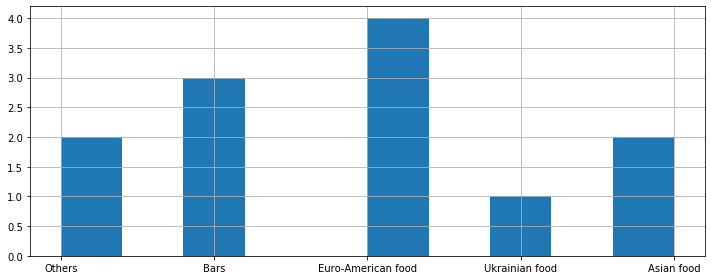

In [89]:
fig = plt.figure(figsize=(10,4))
lviv_venues[lviv_venues['label'] == 1]['new_categories'].hist()
plt.tight_layout()

### Cluster 3: 

  Characteristics:
   - Excellent Quality
   - Mostly **Ukrainian food/ bars /others**

In [90]:
lviv_venues[lviv_venues['label'] == 2]

,id,name,categories,address,lat,lng,likes,likes_cat,new_categories,label
2,54b69c3a498e7aea12b2bba9,Ресторація Бачевських,West-Ukrainian Restaurant,"вул. Шевська, 8",49.842168,24.029843,3439,Excellent,Ukrainian food,2
3,4d03b490e350b60c81b97e42,Львівська майстерня шоколаду,Chocolate Shop,"вул. Сербська, 3",49.841254,24.033434,3713,Excellent,Others,2
5,56350e28498e6c1e1429102d,П'яна Вишня,Wine Bar,"пл. Ринок, 11",49.841522,24.032657,1370,Excellent,Bars,2
17,4ef81686c512f227791e4789,Львівська копальня кави,Coffee Shop,"пл. Ринок, 10",49.841801,24.033202,4573,Excellent,Others,2
22,4bd137e7caff9521946fd0f0,Світ кави / World of Coffee (Світ кави),Coffee Shop,"пл. Катедральна, 6",49.840505,24.030672,1491,Excellent,Others,2
29,5130eb51e4b018c1b228b9c1,Pizza Celentano Ristorante (Піца Челентано),Italian Restaurant,"пл. Ринок, 22",49.841096,24.031043,1701,Excellent,Italian food,2
30,528fc78611d2fae86590fce0,Атляс / Atlas (Атляс),Restaurant,"пл. Ринок, 45",49.842643,24.032041,1803,Excellent,Ukrainian food,2
32,4e0df9b97d8bb178a8a40c62,Перша львівська грильова ресторація м'яса та с...,Steakhouse,"вул. Валова, 20",49.840243,24.035722,3702,Excellent,Euro-American food,2
35,4bc211302a89ef3b3826f388,Кумпель (Ресторан-пивоварня «Кумпель»),Brewery,"вул. Володимира Винниченка, 6",49.839321,24.036042,2521,Excellent,Bars,2
38,4c03c53c187ec928f50db67b,GLORY CAFE,Café,"пл. Адама Міцкевича, 1",49.838514,24.030972,2115,Excellent,Others,2


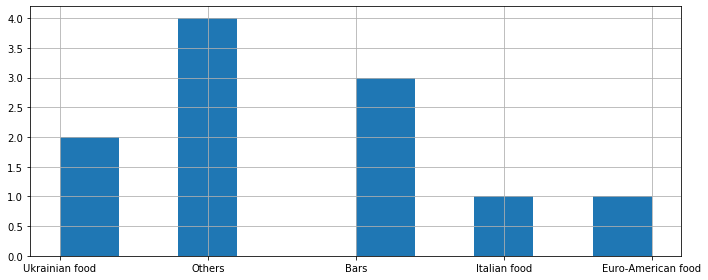

In [92]:
fig = plt.figure(figsize=(10,4))
lviv_venues[lviv_venues['label'] == 2]['new_categories'].hist()
plt.tight_layout()

### Cluster 4: 

  Characteristics:
   - Good Quality
   - Mostly **Others/ Euro-american food / italian food**

In [94]:
lviv_venues[lviv_venues['label'] == 3]

,id,name,categories,address,lat,lng,likes,likes_cat,new_categories,label
8,55f2cd0a498e8eb6624b2ce1,Tante Sophie Cafe Escargot,French Restaurant,"вул. Друкарська, 6A",49.843552,24.032115,609,Good,Euro-American food,3
11,57bb3613498e86d2c0c99f1d,Світ Кави (Світ кави),Coffee Shop,"пл. Ринок, 30",49.841828,24.030580,338,Good,Others,3
12,568fe49f498e56870f8114d4,Реберня «Під Арсеналом»,BBQ Joint,"вул. Підвальна, 5",49.841306,24.035254,1161,Good,Euro-American food,3
19,4bff5a0bc30a2d7fe0e6101d,Split Club Lviv,Restaurant,"пл. Міцкевича, 6/7",49.839297,24.028827,430,Good,Ukrainian food,3
21,557fd7fd498eca6e4d5cfbfb,Celentano Ristorante,Pizza Place,"вул. Шухевича, 3",49.837200,24.034847,521,Good,Italian food,3
24,57239516498e4a0a394fa07d,Black Honey,Coffee Shop,"вул. Костюшка, 2",49.839295,24.025276,388,Good,Others,3
25,4fef25c6e4b0b1e83186060c,Львівська мануфактура кави,Coffee Shop,"вул. Братів Рогатинців, 7",49.839973,24.031301,1054,Good,Others,3
27,52617f0411d23f2f71e102fd,La Vie,Lounge,"вул. Вірменська, 4",49.842965,24.029333,308,Good,Euro-American food,3
28,5853d039ce593d53048eb53a,Cabinet,Café,"вул. Винниченка, 12",49.840473,24.036836,352,Good,Others,3
31,560ad8e6498e227e0460fc6b,Човен / Choven (Човен),Beer Bar,"вул. Вірменська, 33",49.843336,24.033239,671,Good,Bars,3


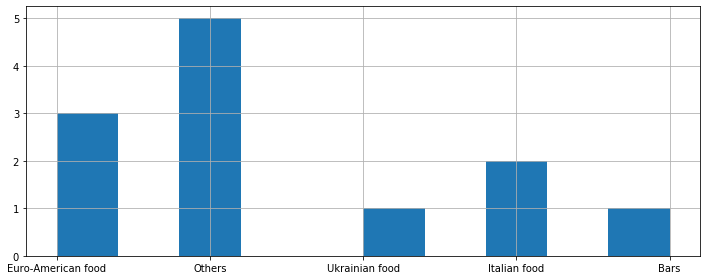

In [95]:
fig = plt.figure(figsize=(10,4))
lviv_venues[lviv_venues['label'] == 3]['new_categories'].hist()
plt.tight_layout()

## Observations

- There are not enough data related to the city of Lviv on Foursquare. Most of the restaurants found are those are 
Ploshcha Rynok (Market Square) in the center of the city. Foursquare might not be very popular in Ukraine
- A lot of restaurant in our dataset have a category **Restaurant**, which doesn't give us much information about the type of meal(ukrainian, italian, ...) the restaurant serves.
- For more accuracy of our classifier, we should get more relevant data about indicator as the **price or average price** of the meal in the restaurant, and We should dig deeper into the analysis for the **quality, quantity, and recency** of the reviews of each restaurant.